<a href="https://colab.research.google.com/github/ZsomBEAST/Deep-Learning-kishazik/blob/main/FONP0O_thirdHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from tensorflow.keras.models import Sequential                  #imports to make keras model
from tensorflow.keras.layers import Dense, Activation,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback 
from tensorflow.keras.optimizers import SGD #we will use stohastic gradient 
import numpy as np
from keras.models import load_model  #we will save the best model and in the end reproduce it
from sklearn import preprocessing #for normalization
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

np.random.seed(123)

import csv # for reading csv
from sklearn.model_selection import train_test_split

In [16]:
predfrom=365 #we can set how much previous temperatuers are the input -> I chose 1 year beacuse i want the network to recognise the changing of the seasons
predto=31 # the out put is 31 days = 1 moth
avgT=[] #list for the database
with open('hom_csv.csv') as csv_file: #load the csv (I have loaded all the data from 'http://idojarasbudapest.hu/archivalt-idojaras' to a CSV file)
    csv_reader = csv.reader(csv_file, delimiter=';') # ';' is the separating character
    line_count = 0 # line counter
    for row in csv_reader:
        if(not(line_count%2)): #the tempreatures are in every 2nd row
            avgT.append((float(row[1])+float(row[2]))/2) #mean=(min+max)/2
            #print(row[1],row[2])
        line_count=line_count+1

#we predict the next 31 day from the last 60 day
avgT_array=np.array(avgT) #make np.array from the list
x_all=[]
y_all=[] #lists for the input and output datas of the netowrk
#making the inputs and the labels
for i in range(predfrom,(len(avgT_array)-predto+1)):
    x_all.append(avgT_array[(i-predfrom):i]) #the input is the pervious 365 day
    y_all.append(avgT_array[i:(i+predto)]) #the label for the cost is the next 31 day

x_test_pre=avgT_array[-predfrom-1:-1] # we will test the prediction the the future, what does it predict for the next month (ofc we are not able to calculate the cost right now)

print(x_test_pre.shape) #the last year
x_test=np.zeros([1,predfrom]) #make a 2D array from the 1D array to match the networks input nd the
x_test[0]=x_test_pre 
print(x_test.shape)

(365,)
(1, 365)


In [17]:
print(len(avgT_array)) #the length of the original avarage temperature dataset
print(len(x_all)) #length of the netowrks input dataset
print(len(y_all)) #length of the netowrks expectation dataset

x_all=np.array(x_all) #We had a list with 1D np.array elemnts so far. Now we make 2D array from that.
y_all=np.array(y_all)

#make the order of the array random ->we dont want that the order influence the learning
randperm = np.random.permutation(len(x_all))
x_all, y_all = x_all[randperm], y_all[randperm]

#split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_all, y_all, test_size=0.2, shuffle=True) # 80% of the data is the train data, 20% is for validation
#the test will be the future predict:)

scaler = preprocessing.StandardScaler().fit(x_train) #normalazie all the inputs by the x_train
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test= scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


3278
2883
2883
(2306, 365)
(2306, 31)
(577, 365)
(577, 31)


In [18]:
patience=20
early_stopping=EarlyStopping(patience=patience, verbose=1) #we are using earlystoping, the laerning usually stops the intesive learning about 250- 30 epochs
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1) #we save the networks wights when the cost is the smallest

model = Sequential()
model.add(Dense(10000, input_shape=(predfrom,))) #we use only 1 hiden layer with 10000 neuron, I have tried lots of variations, this variation has got the best loss/source in my opp.
model.add(Activation('relu'))
model.add(Dropout(0.5)) # we apply dropout as well
model.add(Dense(predto, activation='linear'))


sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) # set the erst of the hyperparameters (by iterations)
model.compile(loss='mse', optimizer=sgd) 
history=model.fit(x_train,y_train,epochs=10000, #we say 10000 epoch but it usually earlystops around 300 
                  batch_size=10, # we use very small batches
                  verbose=2,
                  validation_data=(x_valid, y_valid),
                  callbacks=[checkpointer, early_stopping])


model = load_model('weights.hdf5') #reproduce the best model 

Epoch 1/10000

Epoch 00001: val_loss improved from inf to 14.28726, saving model to weights.hdf5
231/231 - 1s - loss: 22.2688 - val_loss: 14.2873
Epoch 2/10000

Epoch 00002: val_loss improved from 14.28726 to 13.47603, saving model to weights.hdf5
231/231 - 1s - loss: 14.0492 - val_loss: 13.4760
Epoch 3/10000

Epoch 00003: val_loss improved from 13.47603 to 13.04885, saving model to weights.hdf5
231/231 - 1s - loss: 13.2919 - val_loss: 13.0489
Epoch 4/10000

Epoch 00004: val_loss did not improve from 13.04885
231/231 - 1s - loss: 12.8680 - val_loss: 13.0646
Epoch 5/10000

Epoch 00005: val_loss improved from 13.04885 to 12.40481, saving model to weights.hdf5
231/231 - 1s - loss: 12.4877 - val_loss: 12.4048
Epoch 6/10000

Epoch 00006: val_loss improved from 12.40481 to 12.39091, saving model to weights.hdf5
231/231 - 1s - loss: 12.3200 - val_loss: 12.3909
Epoch 7/10000

Epoch 00007: val_loss improved from 12.39091 to 11.95367, saving model to weights.hdf5
231/231 - 1s - loss: 12.0787 - v

The temp on Oct 28 will be:
10.7094145


The temp on Nov 3 will be:
11.39303


The temp on Nov 24 will be:
5.1654625


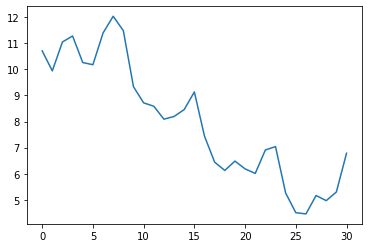

In [19]:
model = load_model('weights.hdf5')
preds = model.predict(x_test) #The test's last input is 10.27's avarage, the first output is 10.28
print("The temp on Oct 28 will be:")
print(preds[0,0])
print('\n')
print("The temp on Nov 3 will be:")
print(preds[0,6])
print('\n')
print("The temp on Nov 24 will be:")
print(preds[0,27])
t=np.linspace(0,predto-1,predto)
plt.plot(t,preds[0,]) #we can check all the 31 data here in a diagram
plt.show() # as we can see the network learned what i wanted, it recognised the next month is november, the temperatures are decrasing